In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(data_id=554) # https://www.openml.org/d/554

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [ ]:
def plot_digits_with_predictions(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).item()
          drawColor = 'black'
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)
        im.set_clim(0, 16)

In [ ]:
mnist_training_data = mnist.data.values[0:60000,:] #Keep the first 60000 samples for training
mnist_training_labels = mnist.target.values[0:60000]
mnist_testing_data = mnist.data.values[60000:,:] #Test on the rest
mnist_testing_labels = mnist.target.values[60000:]

In [ ]:
mnist_training_label_is_three = np.expand_dims(1.0*(mnist_training_labels=='3'),1)
mnist_testing_label_is_three = np.expand_dims(1.0*(mnist_testing_labels=='3'),1)

In [ ]:
mnist_training_label_is_seven = np.expand_dims(1.0*(mnist_training_labels=='7'),1)
mnist_testing_label_is_seven = np.expand_dims(1.0*(mnist_testing_labels=='7'),1)

In [ ]:
mnist_training_label_is_eight = np.expand_dims(1.0*(mnist_training_labels=='8'),1)
mnist_testing_label_is_eight = np.expand_dims(1.0*(mnist_testing_labels=='8'),1)

In [ ]:
mnist_training_label_is_lucky = np.concatenate((mnist_training_label_is_three, mnist_training_label_is_seven))
mnist_training_label_is_lucky = np.concatenate((mnist_training_label_is_lucky, mnist_training_label_is_eight))
mnist_testing_label_is_lucky = np.concatenate((mnist_testing_label_is_three, mnist_testing_label_is_seven))
mnist_testing_label_is_lucky = np.concatenate((mnist_testing_label_is_lucky, mnist_testing_label_is_eight))

In [ ]:
print(mnist_training_data.shape)
print(mnist_testing_label_is_lucky.shape)
print(type(mnist_testing_label_is_lucky))

(60000, 784)
(30000, 1)
<class 'numpy.ndarray'>


In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

class LinearClassifier(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, numClasses)

    def forward(self, x):
        x = x.view(-1,self.flatSize)  #Pytorch will replace -1 with the batch size
        x = self.linear1(x)
        return x

In [ ]:
three_training_dataset = NumpyDataset(mnist_training_data,mnist_training_label_is_three)
three_testing_dataset = NumpyDataset(mnist_testing_data,mnist_testing_label_is_three)

In [ ]:
seven_training_dataset = NumpyDataset(mnist_training_data,mnist_training_label_is_seven)
seven_testing_dataset = NumpyDataset(mnist_testing_data,mnist_testing_label_is_seven)

In [ ]:
eight_training_dataset = NumpyDataset(mnist_training_data,mnist_training_label_is_eight)
eight_testing_dataset = NumpyDataset(mnist_testing_data,mnist_testing_label_is_eight)

In [ ]:
lucky_training_dataset = NumpyDataset(mnist_training_data,mnist_training_label_is_lucky)
lucky_testing_dataset =  NumpyDataset(mnist_testing_data,mnist_testing_label_is_lucky)

In [ ]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

In [ ]:
def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

In [ ]:
def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

In [ ]:
def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

In [ ]:
def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [ ]:
def computeLabelAccuracy(model, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      correct += (output>0).eq(target>0).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
def MSE(output, target): #L2 Loss - same as nn.MSELoss()
   loss = torch.mean((output - target)**2)
   return loss

def SigmoidLoss(output, target): #L2 Loss - same as nn.MSELoss()
   loss = torch.mean((torch.sigmoid(output) - target)**2)
   return loss

Loaded Data
Epoch [1/30], Train Loss: 0.0958, Test Loss: 0.0527
Epoch [6/30], Train Loss: 0.0293, Test Loss: 0.0261
Epoch [11/30], Train Loss: 0.0252, Test Loss: 0.0224
Epoch [16/30], Train Loss: 0.0236, Test Loss: 0.0213
Epoch [21/30], Train Loss: 0.0231, Test Loss: 0.0215
Epoch [26/30], Train Loss: 0.0221, Test Loss: 0.0205


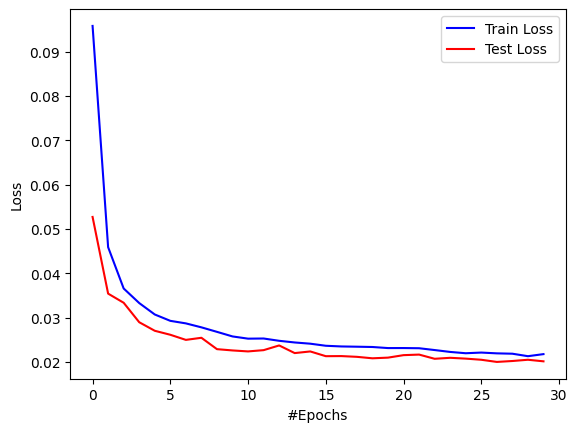

In [ ]:
############################################ 33333333333333333333333333333333333333333333333333333333333 ########################################################################

num_epochs = 30
print_interval = 5
learning_rate = 0.0001
batch_size = 100

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = LinearClassifier(image_w, image_h, 1)

#Set optimizer and loss function
model3 = predModel;
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = SigmoidLoss #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator3 = torch.utils.data.DataLoader(three_training_dataset, batch_size=batch_size, shuffle=True)
testing_generator3 = torch.utils.data.DataLoader(three_testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model3, training_generator3, testing_generator3, loss_function, optimizer, num_epochs, learning_rate, print_interval)

Loaded Data
Epoch [1/30], Train Loss: 0.0630, Test Loss: 0.0282
Epoch [6/30], Train Loss: 0.0176, Test Loss: 0.0173
Epoch [11/30], Train Loss: 0.0151, Test Loss: 0.0160
Epoch [16/30], Train Loss: 0.0141, Test Loss: 0.0147
Epoch [21/30], Train Loss: 0.0137, Test Loss: 0.0152
Epoch [26/30], Train Loss: 0.0130, Test Loss: 0.0152


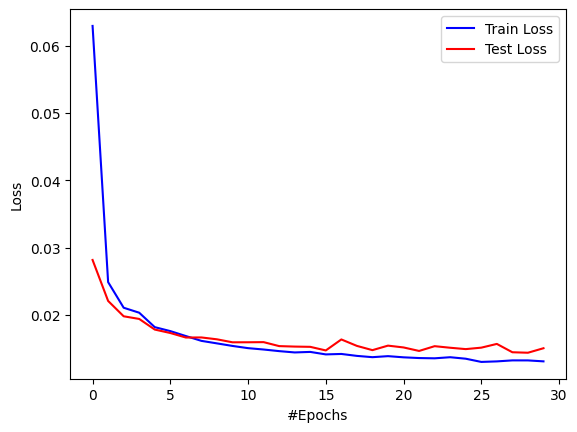

In [ ]:
############################################ 7777777777777777777777777777777777777777777777777777777777777777777777777 ########################################################################

num_epochs = 30
print_interval = 5
learning_rate = 0.0001
batch_size = 100

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = LinearClassifier(image_w, image_h, 1)

#Set optimizer and loss function
model7 = predModel;
optimizer = torch.optim.Adam(model7.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = SigmoidLoss #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator7 = torch.utils.data.DataLoader(seven_training_dataset, batch_size=batch_size, shuffle=True)
testing_generator7 = torch.utils.data.DataLoader(seven_testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model7, training_generator7, testing_generator7, loss_function, optimizer, num_epochs, learning_rate, print_interval)

Loaded Data
Epoch [1/30], Train Loss: 0.1040, Test Loss: 0.0976
Epoch [6/30], Train Loss: 0.0975, Test Loss: 0.0974
Epoch [11/30], Train Loss: 0.0975, Test Loss: 0.0974
Epoch [16/30], Train Loss: 0.0975, Test Loss: 0.0974
Epoch [21/30], Train Loss: 0.0975, Test Loss: 0.0974
Epoch [26/30], Train Loss: 0.0975, Test Loss: 0.0974


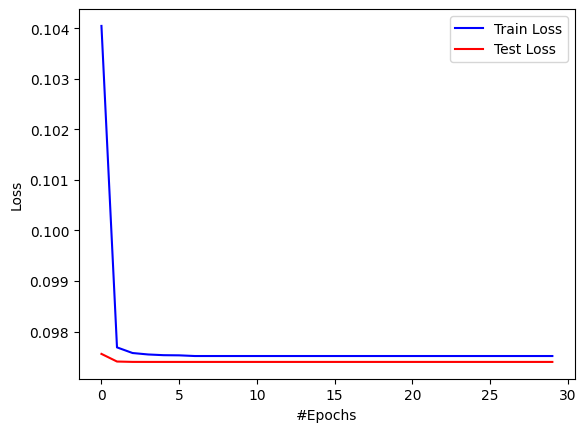

In [ ]:
############################################ 88888888888888888888888888888888888888888888888888888888888888888 ########################################################################

num_epochs = 30
print_interval = 5
learning_rate = 0.0001
batch_size = 100

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = LinearClassifier(image_w, image_h, 1)

#Set optimizer and loss function
model8 = predModel;
optimizer = torch.optim.Adam(model8.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = SigmoidLoss #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator8 = torch.utils.data.DataLoader(eight_training_dataset, batch_size=batch_size, shuffle=True)
testing_generator8 = torch.utils.data.DataLoader(eight_testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model8, training_generator8, testing_generator8, loss_function, optimizer, num_epochs, learning_rate, print_interval)

Loaded Data
Epoch [1/40], Train Loss: 0.0857, Test Loss: 0.0472
Epoch [6/40], Train Loss: 0.0282, Test Loss: 0.0251
Epoch [11/40], Train Loss: 0.0254, Test Loss: 0.0224
Epoch [16/40], Train Loss: 0.0236, Test Loss: 0.0216
Epoch [21/40], Train Loss: 0.0227, Test Loss: 0.0240
Epoch [26/40], Train Loss: 0.0222, Test Loss: 0.0215
Epoch [31/40], Train Loss: 0.0217, Test Loss: 0.0207
Epoch [36/40], Train Loss: 0.0210, Test Loss: 0.0199


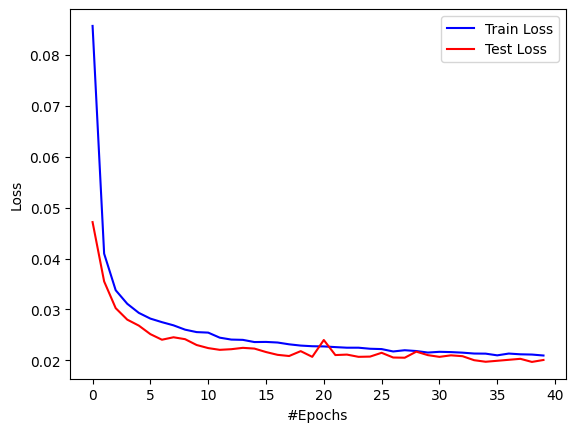

In [ ]:
num_epochs = 40
print_interval = 5
learning_rate = 0.0001
batch_size = 100

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = LinearClassifier(image_w, image_h, 1)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = SigmoidLoss #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator_l = torch.utils.data.DataLoader(lucky_training_dataset, batch_size=batch_size, shuffle=True)
testing_generator_l= torch.utils.data.DataLoader(lucky_testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator_l, testing_generator_l, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
computeLabelAccuracy(model3, training_generator3, "Test Set")
computeLabelAccuracy(model3, testing_generator3, "Train Set")


Test Set: Accuracy: 58719/60000 (97.9%)

Train Set: Accuracy: 9792/10000 (97.9%)


In [ ]:
computeLabelAccuracy(model7, training_generator7, "Test Set")
computeLabelAccuracy(model7, testing_generator7, "Train Set")


Test Set: Accuracy: 59219/60000 (98.7%)

Train Set: Accuracy: 9845/10000 (98.4%)


In [ ]:
computeLabelAccuracy(model8, training_generator8, "Test Set")
computeLabelAccuracy(model8, testing_generator8, "Train Set")


Test Set: Accuracy: 54149/60000 (90.2%)

Train Set: Accuracy: 9026/10000 (90.3%)


In [ ]:
computeLabelAccuracy(model, training_generator_l, "Test Set")
computeLabelAccuracy(model, testing_generator_l, "Train Set")


Test Set: Accuracy: 58731/60000 (97.9%)

Train Set: Accuracy: 9794/10000 (97.9%)


In [ ]:
# preds = model(torch.tensor(mnist_testing_data).float()).detach().numpy()
# fpr, tpr, thresholds = metrics.roc_curve(mnist_testing_label_is_lucky,preds)
# plt.plot(fpr,tpr)
# plt.title("ROC Curve")
# print("AUC:",metrics.auc(fpr, tpr))
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# p,r,f,count = metrics.precision_recall_fscore_support(mnist_testing_label_is_lucky,preds>0)
# print("Precision",p)
# print("Recall",r)
# print("F1",f)
# print("Count",count)

In [ ]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from __future__ import print_function
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import imutils
import cv2
import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import datasets
from skimage import exposure


In [ ]:
mnist_data = datasets.load_digits()

In [ ]:
training_Data, testing_Data, training_Labels, testing_Labels = train_test_split(np.array(mnist.data), mnist.target, test_size=0.2, random_state=74)

In [ ]:
training_Data, test_Data, training_Labels, test_Labels = train_test_split(training_Data, training_Labels, test_size=0.1, random_state=21)

In [ ]:
kVals = range(1, 10, 2)
accuracies = []

for k in range(1, 10, 2):

	model = KNeighborsClassifier(n_neighbors=k)
	model.fit(training_Data, training_Labels)

	# evaluate the model and update the accuracies list
	score = model.score(test_Data, test_Labels)
	print("k=%d, accuracy=%.2f%%" % (k, score * 100))
	accuracies.append(score)

i = int(np.argmax(accuracies))
print("k=%d achieved highest accuracy of %.2f%%" % (kVals[i],
	accuracies[i] * 100))

k=1, accuracy=97.27%
k=3, accuracy=97.23%
k=5, accuracy=97.23%
k=7, accuracy=97.14%
k=9, accuracy=97.07%
k=1 achieved highest accuracy of 97.27%


In [ ]:
model = KNeighborsClassifier(5)
model.fit(training_Data, training_Labels)
predictions = model.predict(test_Data)

print(classification_report(test_Labels, predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       513
           1       0.96      0.99      0.98       669
           2       0.99      0.97      0.98       588
           3       0.97      0.97      0.97       564
           4       0.98      0.97      0.97       522
           5       0.97      0.96      0.96       519
           6       0.97      0.99      0.98       569
           7       0.96      0.98      0.97       584
           8       0.99      0.93      0.96       517
           9       0.95      0.97      0.96       555

    accuracy                           0.97      5600
   macro avg       0.97      0.97      0.97      5600
weighted avg       0.97      0.97      0.97      5600



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

torch.set_printoptions(sci_mode=False)

In [ ]:
mnist_training_data = mnist.data.values[0:60000,:] #Keep the first 60000 samples for training
mnist_training_labels = mnist.target.values[0:60000]
mnist_testing_data = mnist.data.values[60000:,:] #Test on the rest
mnist_testing_labels = mnist.target.values[60000:]

In [ ]:
mnist_training_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_training_labels.to_numpy().astype(int))).long()).numpy()
mnist_testing_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_testing_labels.to_numpy().astype(int))).long()).numpy()

In [ ]:
training_dataset = NumpyDataset(mnist_training_data,mnist_training_labels_catigories)
testing_dataset = NumpyDataset(mnist_testing_data,mnist_testing_labels_catigories)

In [ ]:
class Classifier_3Layers(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, 20)  #Multiple matrix "layers"
        self.linear2 = nn.Linear(20, 15)             #This is 784->20->15->10 ...
        self.linear3 = nn.Linear(15, numClasses)     #... try different options

    def forward(self, x):
        x = x.view(-1,self.flatSize)   #Pytorch will replace -1 with the batch size
        x = torch.abs(self.linear1(x)) # "abs" and/or "relu" are example of non-linear tranformations
        x = F.relu(self.linear2(x))    # 'relu' keeps positive numbers same, sets negative numbers to 0
        x = self.linear3(x)
        return x

Loaded Data
Epoch [1/30], Train Loss: 0.9230, Test Loss: 0.3497
Epoch [6/30], Train Loss: 0.1719, Test Loss: 0.2078
Epoch [11/30], Train Loss: 0.1293, Test Loss: 0.1850
Epoch [16/30], Train Loss: 0.1122, Test Loss: 0.2071
Epoch [21/30], Train Loss: 0.1009, Test Loss: 0.1885
Epoch [26/30], Train Loss: 0.0937, Test Loss: 0.2074


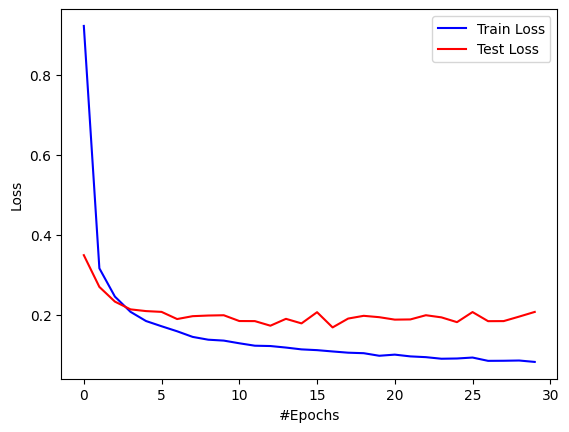

In [ ]:
#Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.001
batch_size = 200

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = Classifier_3Layers(image_w, image_h, 10)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = nn.CrossEntropyLoss() #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
def computeLabelAccuracyN(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      true_labels = target.data.max(1, keepdim=True)[1]
      correct += pred.eq(true_labels.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
computeLabelAccuracyN(model, training_generator, "Test Set")
computeLabelAccuracyN(model, testing_generator, "Train Set")


Test Set: Accuracy: 58488/60000 (97.5%)

Train Set: Accuracy: 9547/10000 (95.5%)


Text(70.72222222222221, 0.5, 'Predicted Class')

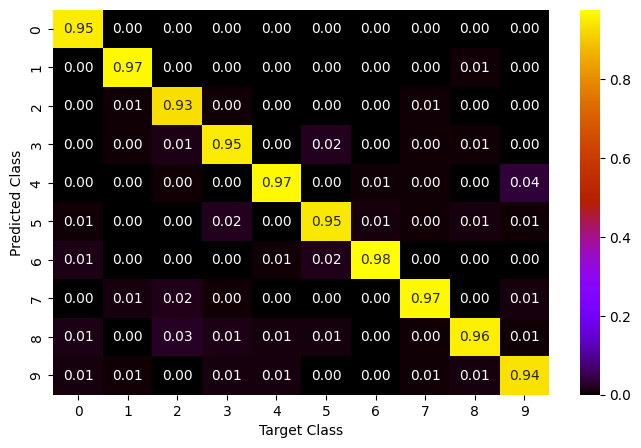

In [ ]:
data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=10000)
data_enumerator = enumerate(data_generator)
_, (images,labels) = next(data_enumerator)
with torch.no_grad():
    pred_catigories = model(images) #all 10 values
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
    true_labels = labels.data.max(1, keepdim=True)[1]
conf_mat = confusion_matrix(true_labels.numpy(), pred_labels.numpy(), normalize = "pred")
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt="0.2f", cmap = "gnuplot") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
plt.xlabel("Target Class")
plt.ylabel("Predicted Class")

In [ ]:
def plot_digits_with_mnist_predictionsN(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).max(1, keepdim=True)[1].item()
          true_label = np.argmax(labels[i])
          drawColor = 'black'
          if pred_label != true_label:
            drawColor = 'red'
          axi.set_title("label:{}\npred:{}".format(true_label,pred_label), color=drawColor)
        im.set_clim(0, 16)

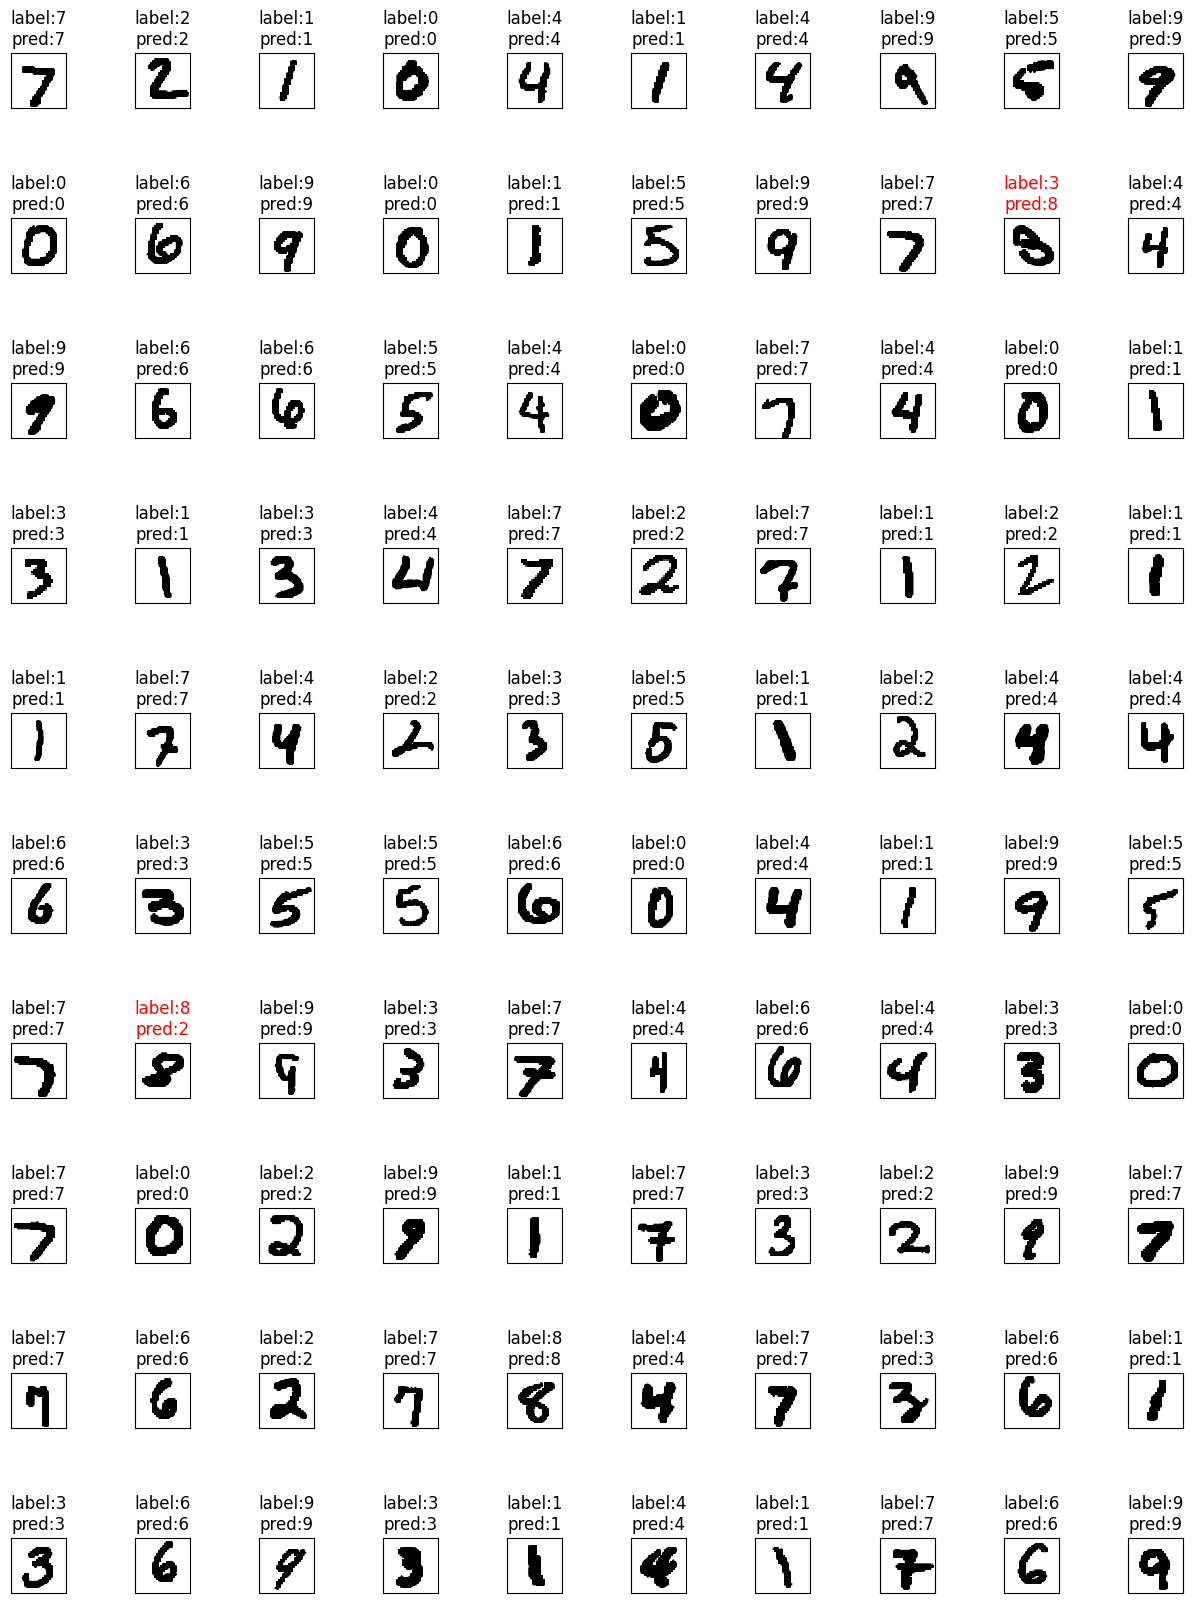

In [ ]:
plot_digits_with_mnist_predictionsN(model, mnist_testing_data, mnist_testing_labels_catigories)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)

In [ ]:
mnist_training_data = mnist.data.values[0:10000,:] #Keep the first 10000 samples for training
mnist_training_labels = mnist.target.values[0:10000]
mnist_testing_data = mnist.data.values[10000:,:] #Test on the rest
mnist_testing_labels = mnist.target.values[10000:]

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [ ]:
pca = PCA(0.95, whiten=True)           #Fit 95% of the variation
mnist_data_pca = pca.fit_transform(mnist_training_data)
mnist_data_pca.shape

(10000, 150)

In [ ]:
mnist_nines = mnist_training_data[mnist_training_labels=='9']
mnist_eights = mnist_training_data[mnist_training_labels=='8']
mnist_sevens = mnist_training_data[mnist_training_labels=='7']
mnist_sixes = mnist_training_data[mnist_training_labels=='6']
mnist_fives = mnist_training_data[mnist_training_labels=='5']
mnist_fours = mnist_training_data[mnist_training_labels=='4']
mnist_threes = mnist_training_data[mnist_training_labels=='3']
mnist_twos = mnist_training_data[mnist_training_labels=='2']
mnist_ones = mnist_training_data[mnist_training_labels=='1']
mnist_zeros = mnist_training_data[mnist_training_labels=='0']
mnist_nines_pca = pca.transform(mnist_nines)
mnist_eights_pca = pca.transform(mnist_eights)
mnist_sevens_pca = pca.transform(mnist_sevens)
mnist_sixes_pca = pca.transform(mnist_sixes)
mnist_fives_pca = pca.transform(mnist_fives)
mnist_fours_pca = pca.transform(mnist_fours)
mnist_threes_pca = pca.transform(mnist_threes)
mnist_twos_pca = pca.transform(mnist_twos)
mnist_ones_pca = pca.transform(mnist_ones)
mnist_zeros_pca = pca.transform(mnist_zeros)

In [ ]:
gmm = GaussianMixture(8, covariance_type='full', random_state=0)
gmm.fit(mnist_nines_pca)
print(gmm.converged_)

True


In [ ]:
def plot_digits(data,img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
        im.set_clim(0, 16)

508


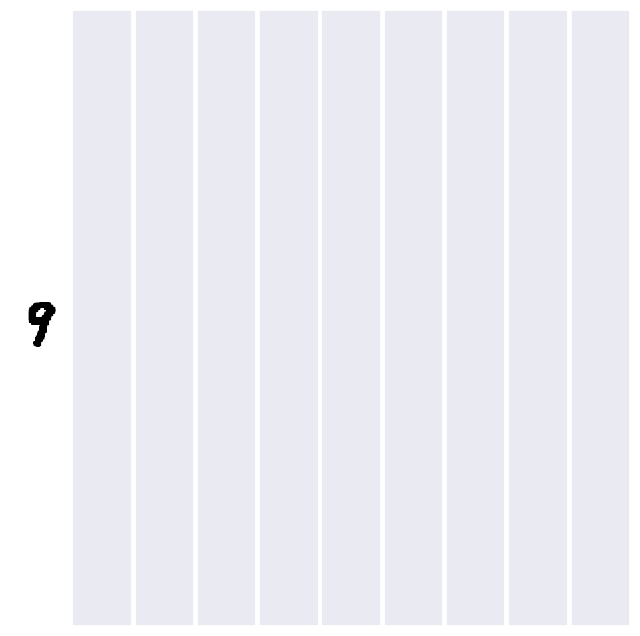

In [ ]:
x = np.argmax(gmm.score_samples(mnist_nines_pca))
print(x)
plot_digits(mnist_nines[x:x+1,:], 28, 1)

870


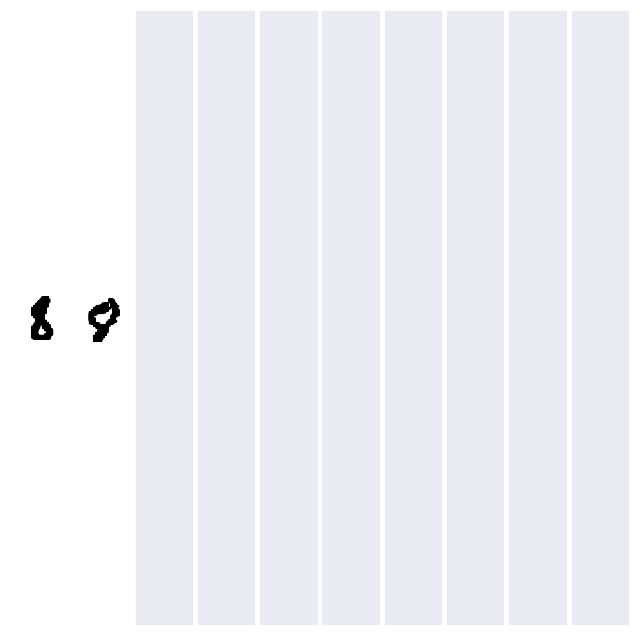

In [ ]:
x = np.argmax(gmm.score_samples(mnist_eights_pca))
print(x)
plot_digits(mnist_eights[x-1:x+1,:], 28, 1)

311


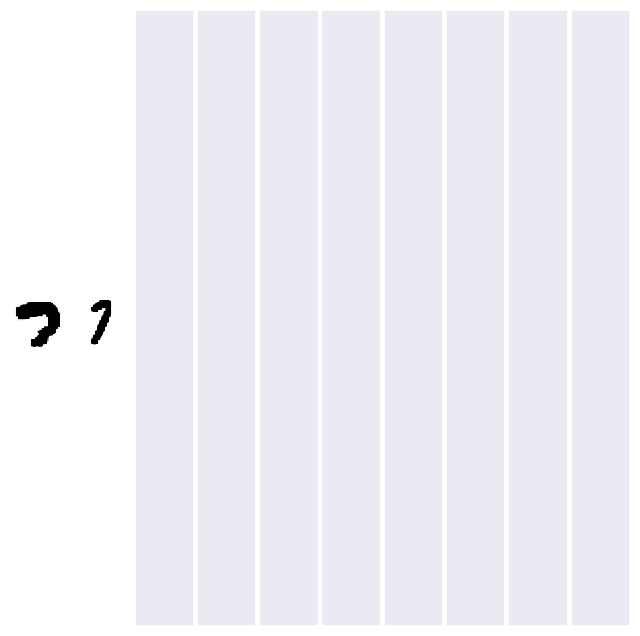

In [ ]:
x = np.argmax(gmm.score_samples(mnist_sevens_pca))
print(x)
plot_digits(mnist_sevens[x-1:x+1,:], 28, 1)

839


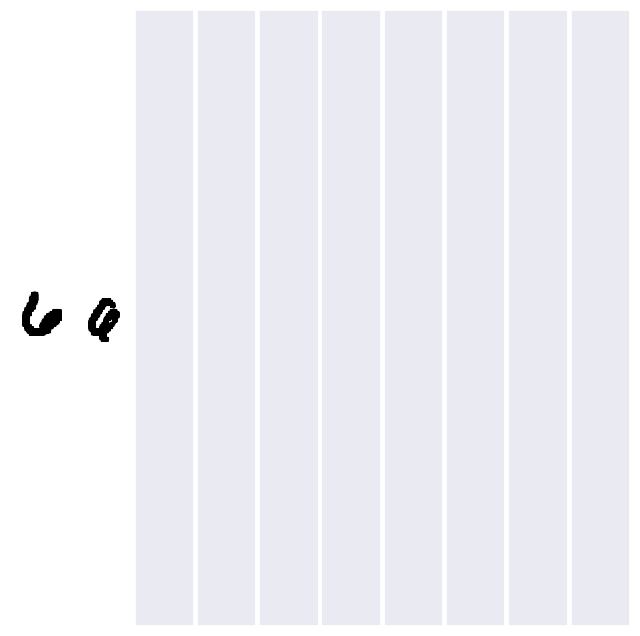

In [ ]:
x = np.argmax(gmm.score_samples(mnist_sixes_pca))
print(x)
plot_digits(mnist_sixes[x-1:x+1,:], 28, 1)

33


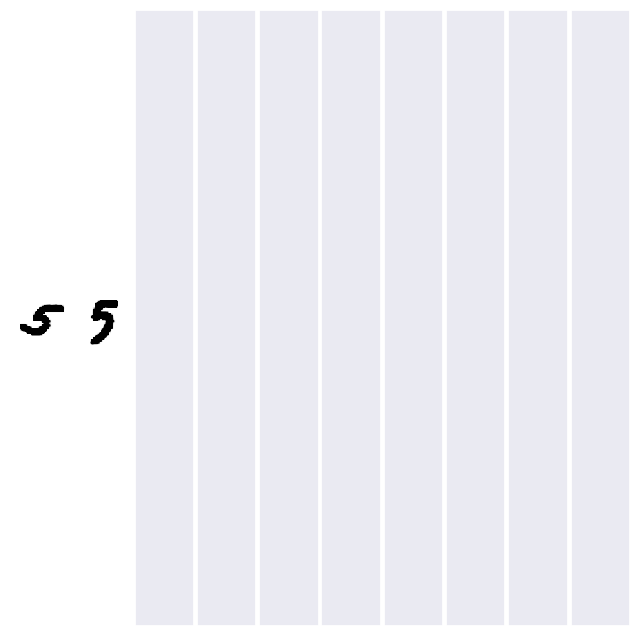

In [ ]:
x = np.argmax(gmm.score_samples(mnist_fives_pca))
print(x)
plot_digits(mnist_fives[x-1:x+1,:], 28, 1)

479


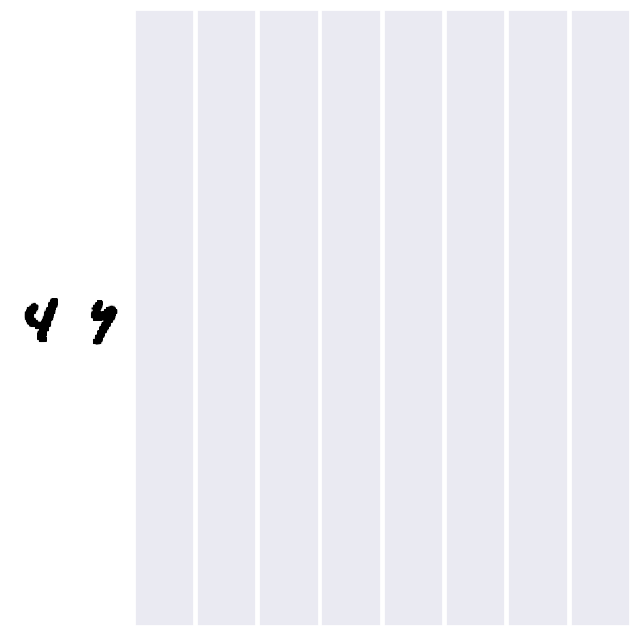

In [ ]:
x = np.argmax(gmm.score_samples(mnist_fours_pca))
print(x)
plot_digits(mnist_fours[x-1:x+1,:], 28, 1)

306


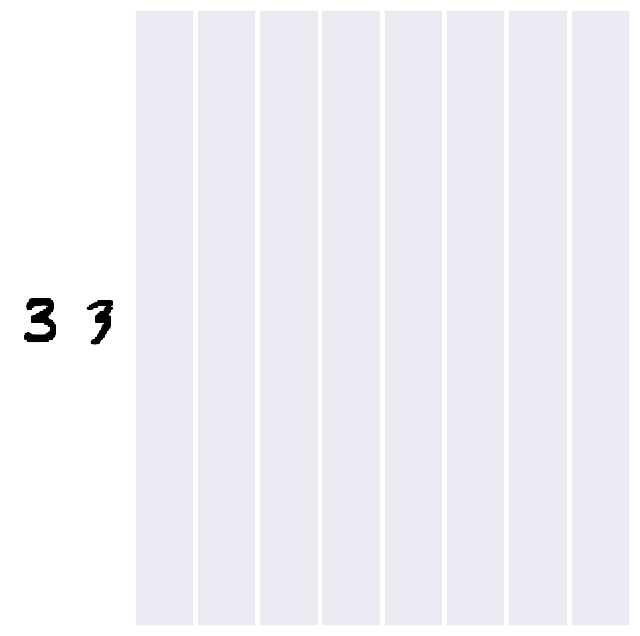

In [ ]:
x = np.argmax(gmm.score_samples(mnist_threes_pca))
print(x)
plot_digits(mnist_threes[x-1:x+1,:], 28, 1)

413


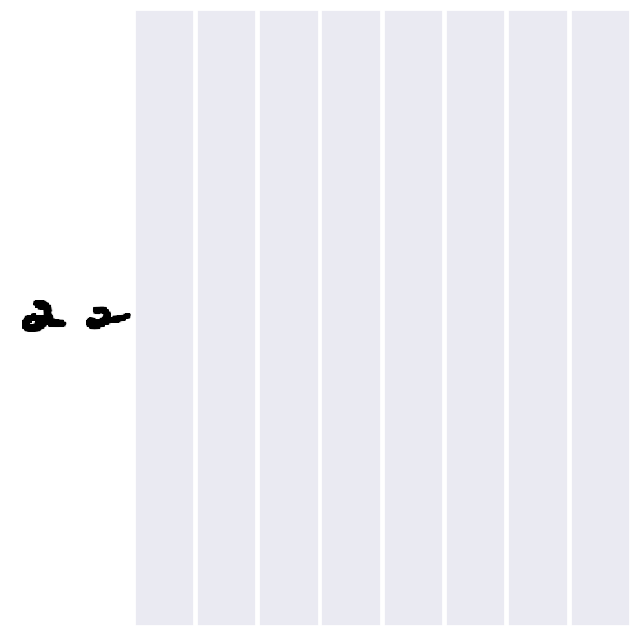

In [ ]:
x = np.argmax(gmm.score_samples(mnist_twos_pca))
print(x)
plot_digits(mnist_twos[x-1:x+1,:], 28, 1)

703


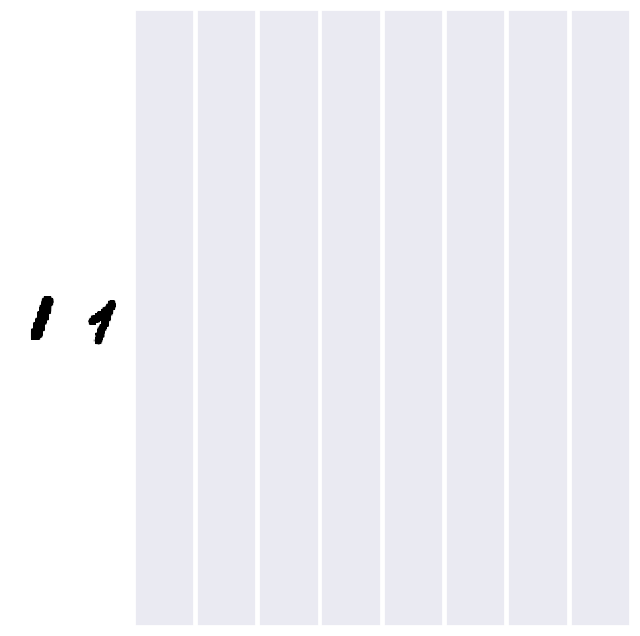

In [ ]:
x = np.argmax(gmm.score_samples(mnist_ones_pca))
print(x)
plot_digits(mnist_ones[x-1:x+1,:], 28, 1)

847


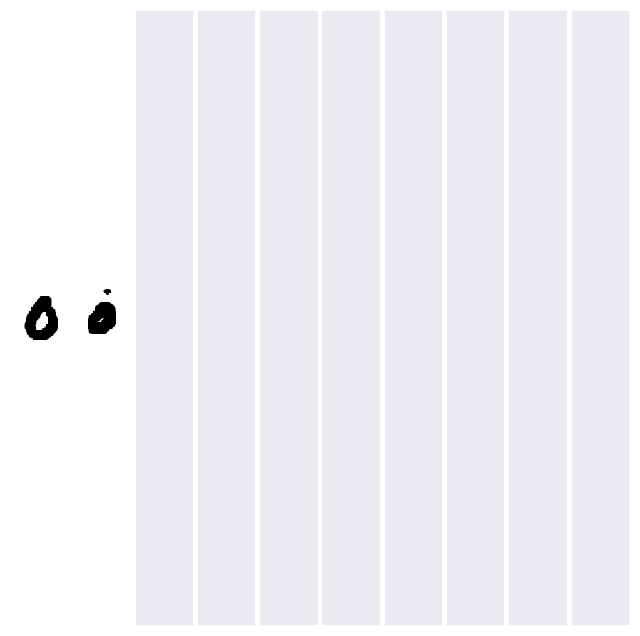

In [ ]:
x = np.argmax(gmm.score_samples(mnist_zeros_pca))
print(x)
plot_digits(mnist_zeros[x-1:x+1,:], 28, 1)

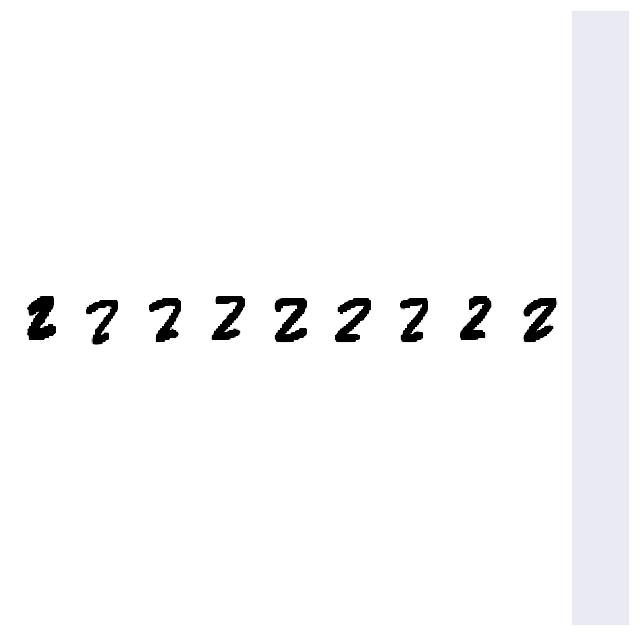

In [ ]:
mnist_zeros_testing = mnist_testing_data[mnist_testing_labels=='2']
mnist_zeros_testing_pca = pca.transform(mnist_zeros_testing);
x = np.argmax(gmm.score_samples(mnist_zeros_testing_pca))
plot_digits(mnist_zeros_testing[x-1:x+8,:], 28, 1)

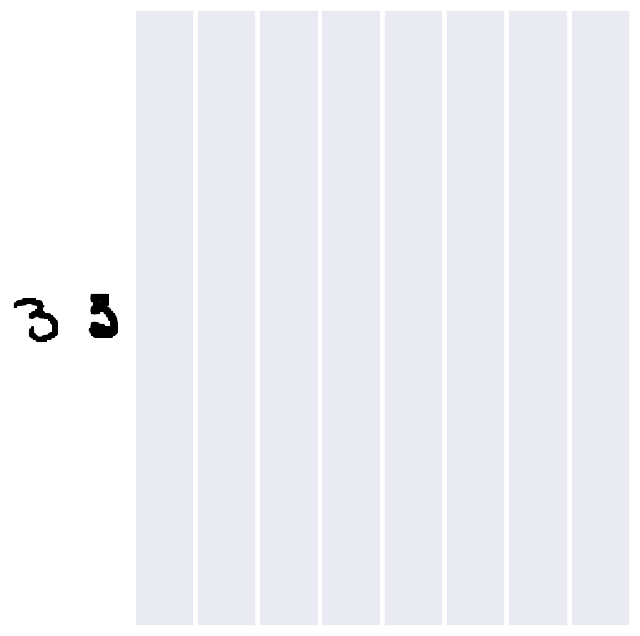

In [ ]:
mnist_sevens_testing = mnist_testing_data[mnist_testing_labels=='3']
mnist_sevens_testing_pca = pca.transform(mnist_sevens_testing);
x = np.argmin(gmm.score_samples(mnist_sevens_testing_pca))
plot_digits(mnist_sevens_testing[x-1:x+1,:], 28, 1)

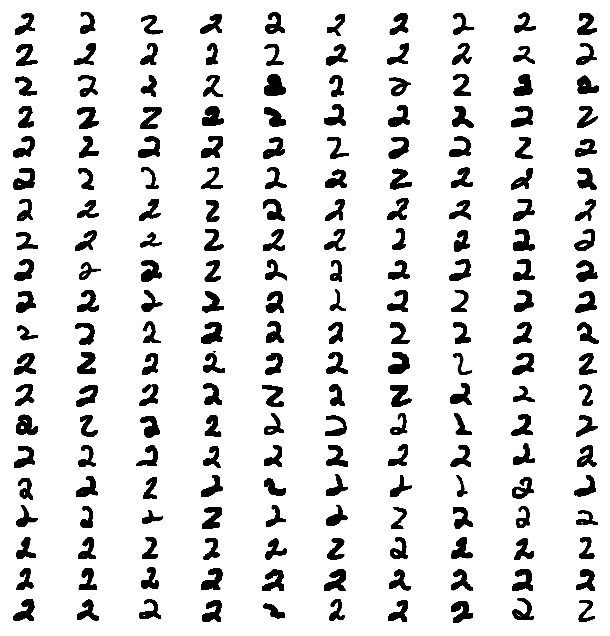

In [ ]:
mnist_fours_testing = mnist_testing_data[mnist_testing_labels=='2']
mnist_fours_testing_pca = pca.transform(mnist_fours_testing);
x = np.argmax(gmm.score_samples(mnist_fours_testing_pca))
plot_digits(mnist_fours_testing[0:1000,:], 28, 20)